## Goals:

**1. Determine drivers of sentiment in the flavor text in Magic: The Gathering cards.**

**2. Develop a model to predict the sentiment of flavor text in Magic: The Gathering cards.**

In [1]:
# imports and display options

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

import prepare as p

pd.set_option('display.max_colwidth', -1)

# Acquire

1. A CSV, containing an up to date breakdown of each Magic card that has been printed so far, was obtained from MTGJSON.com. Each row represented a card or a version of a card.The dataframe contained 50,412 rows and 71 columns.

2. The CSV was read into a pandas dataframe

# Prepare

1. Restricted dataframe to only to columns I considered to be relevant. (colorIdentity, types, convertedManaCost, rarity, flavorText, isPaper)
 
2. Restricted dataframe to only rows containing cards that exist in physical form

3. Restricted dataframe to only row containing a flavor text

4. Restricted dataframe to only rows with a single color-identity

5. Merged rows with similar or overlapping types into one of the seven major game types

6. Restricted dataframe to include only rows with a single type belonging to one of the major game types

7. Cleaned up flavor text then aggregated on flavorText in an attempt to eliminate duplicates. This game me some success. However, it is likely that a few duplicates remain.

8. Reordered columns

9. Restricted dataframe to rows with English flavor text 

10. Dropped rows with duplicates I happened to spot

11. Added sentiment column showing compound sentiment score using VADER

12. Added intensity column showing the absolute value of the compound sentiment score 

In [2]:
# load and prepare data
#df = p.prepare_mgt(p.wrangle_mtg())

In [3]:
#df.to_csv('mtgprep.csv', index=False)

In [4]:
df = pd.read_csv('mtgprep.csv')

In [5]:
df=df.drop([7968,6562]) # drop found duplicates

In [6]:
df.head(5)

,colorIdentity,types,convertedManaCost,rarity,flavorText,sentiment,intensity
0,Green,Creature,5.0,common,""" . . . And the third little boar built his house out of rootwalla plates . . . .""",0.0000,0.0000
1,Black,Creature,1.0,common,""" . . . Cao Pi, Cao Rui, Fang, Mao, and briefly, Huan— The Sima took the empire in their turn. . . .""",0.0000,0.0000
2,Blue,Creature,5.0,uncommon,""" . . . When the trees bow down their heads, The wind is passing by.""",0.0000,0.0000
3,White,Creature,4.0,uncommon,""" . . . and you must also apply for an application license, file documents 136(iv) and 22-C and -D in triplicate, pay all requisite fees, request a . . .""",-0.1027,0.1027
4,Green,Creature,4.0,common,"""'Air superiority?' Not while our archers scan the skies.""",0.0000,0.0000


# Explore

### What does the data look like?

In [7]:
df.shape

(12448, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12448 entries, 0 to 12449
Data columns (total 7 columns):
colorIdentity        12448 non-null object
types                12448 non-null object
convertedManaCost    12448 non-null float64
rarity               12448 non-null object
flavorText           12448 non-null object
sentiment            12448 non-null float64
intensity            12448 non-null float64
dtypes: float64(3), object(4)
memory usage: 778.0+ KB


In [9]:
df.describe()

,convertedManaCost,sentiment,intensity
count,12448.00000,12448.000000,12448.000000
mean,3.17541,-0.024462,0.321027
std,1.61158,0.422989,0.276498
min,0.00000,-0.979200,0.000000
25%,2.00000,-0.340000,0.000000
50%,3.00000,0.000000,0.318200
75%,4.00000,0.296000,0.542300
max,15.00000,0.954500,0.979200


In [10]:
df.sort_values('sentiment').head(10)

,colorIdentity,types,convertedManaCost,rarity,flavorText,sentiment,intensity
5112,Black,Creature,3.0,common,"""We mourn our dead. We shroud our dead. We bury our dead. Too often, it seems, we must kill our dead again.""",-0.9792,0.9792
2943,White,Creature,6.0,uncommon,"""No more fear. No more failure. No more death. No more!""",-0.9605,0.9605
9135,White,Enchantment,2.0,uncommon,"No one spoke. There was no need. The threat of the Eldrazi presented a simple choice: lay down your weapons and die for nothing, or hold them fast and die for something.",-0.9552,0.9552
2434,Black,Enchantment,3.0,uncommon,"""Kill a creature, destroy the present. Kill the land, destroy the future.""",-0.9545,0.9545
11432,Black,Creature,3.0,common,"There are laws against it, but the dead have no one to complain to and the living are too frightened to investigate.",-0.9505,0.9505
7752,Black,Creature,4.0,common,"Heartless killer in life, brainless killer in death.",-0.9493,0.9493
9904,Red,Creature,5.0,common,"Some tried cremating their dead to stop the ghoulcallers. But the dead returned, furious about their fate.",-0.9455,0.9455
4705,Black,Enchantment,3.0,uncommon,"""This pestilence robs us of glorious death in battle. We starve to death with full bellies and drown trying to slake our unnatural thirst.""",-0.9413,0.9413
3319,Red,Instant,1.0,common,"""Rage is a dangerous weapon. Your enemies will try to use your anger against you. Use it against them first.""",-0.9413,0.9413
1212,Red,Enchantment,3.0,common,"""Goblins charge with a deafening war cry. The cry doesn't mean anything—it just drowns out the drums!""",-0.9412,0.9412


In [11]:
df.sort_values('sentiment',ascending=False).head(10)

,colorIdentity,types,convertedManaCost,rarity,flavorText,sentiment,intensity
9887,Blue,Creature,3.0,common,"Some spectators love an underdog, but others are just as happy to support a proven winner.",0.9545,0.9545
8850,Green,Instant,2.0,common,"MORE TO LOVE: Friendly, nature-loving, Bunyonesque SEM seeks SEF looking for a huge commitment. . . . seeks atog prince",0.9426,0.9426
3853,White,Creature,2.0,common,"""The aven are heralds of divinity. The greatest glory is to join them in the sky.""",0.9274,0.9274
11773,White,Creature,2.0,rare,"To become an officer, an Icatian Soldier had to pass a series of tests. These evaluated not only fighting and leadership skills, but also integrity, honor, and moral strength.",0.9268,0.9268
5313,White,Instant,1.0,common,"""When I wish to be strong, I train. When I wish to be wise, I study. When I wish to rest, I start again.""",0.9260,0.9260
7967,Green,Creature,4.0,common,"If you find yourself and a friend being chased by a King Cheetah, you have but one chance: Trip your friend. —Suq'Ata wisdom",0.9260,0.9260
4610,Red,Enchantment,5.0,uncommon,"""They said obey and you'll be happy. They said you'll be safe. But we're not safe. We're not happy. And we will not obey.""",0.9217,0.9217
6563,White,Creature,2.0,common,"Before a woman marries in the village of Sursi, she must visit the land of the mesa pegasus. Legend has it that if the woman is pure of heart and her love is true, a mesa pegasus will appear, blessing her family with long life and good fortune.",0.9201,0.9201
8019,Green,Creature,3.0,uncommon,"In a culture of beauty, the most beautiful are worshipped as gods.",0.9179,0.9179
10723,White,Creature,4.0,common,"The great hart stood like a statue, its hide painted gold by the dawn. The Champion laid down her weapons and stepped forward within an arm's length of the beast. The hart, sacred to Heliod and bathed in the god's own light, bowed to the Champion, marking her as the Chosen of the Sun God. —The Theriad",0.9169,0.9169


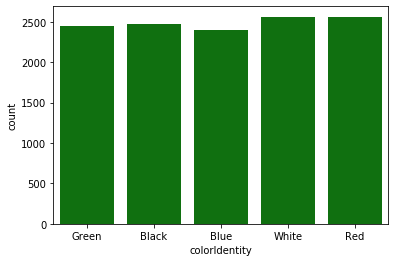

In [12]:
import seaborn

seaborn.countplot(x='colorIdentity', data=df, color='Green')

In [ ]:
plt.bar(df.colorIdentity,df.sentiment)

<BarContainer object of 12448 artists>

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a1f44c9e0> (for post_execute):


KeyboardInterrupt: 

### How balanced in the data?

In [13]:
for column in df.columns:
    
    print(f'{column} value counts')
    print(df[f'{column}'].value_counts())
    print('')

colorIdentity value counts
Red      2563
White    2556
Black    2473
Green    2453
Blue     2403
Name: colorIdentity, dtype: int64

types value counts
Creature        6978
Instant         2016
Sorcery         1762
Enchantment     1573
Land            77  
Artifact        41  
Planeswalker    1   
Name: types, dtype: int64

convertedManaCost value counts
3.0     3037
2.0     2882
4.0     2289
1.0     1734
5.0     1397
6.0     645 
7.0     244 
8.0     90  
0.0     80  
9.0     29  
10.0    11  
11.0    5   
12.0    2   
15.0    1   
14.0    1   
0.5     1   
Name: convertedManaCost, dtype: int64

rarity value counts
common      5927
uncommon    3643
rare        2715
mythic      163 
Name: rarity, dtype: int64

flavorText value counts
A vertical scream pierces the night air and echoes doom through the clouds.                                                                        1
The Elves gathered huge piles of rot to grow fungus. Out of imitation or forethought, the Thallids did the s

In [14]:
df.colorIdentity.plot()
    

TypeError: no numeric data to plot

In [ ]:
df[df.sentiment==0].count()/df.sentiment.count()

# remove 7968 6562

In [ ]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.colorIdentity==f'{color}'].sentiment.mean()
      
    print(f'{color}: {number}')

In [ ]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.colorIdentity==f'{color}'].intensity.mean()
      
    print(f'{color}: {number}')

In [ ]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.colorIdentity==f'{color}'].intensity.median()
      
    print(f'{color}: {number}')

In [ ]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.colorIdentity==f'{color}'][df.sentiment!=0].sentiment.median()
      
    print(f'{color}: {number}')

In [ ]:
df[df.sentiment==0].colorIdentity.value_counts()

In [ ]:
rarity = ['common','uncommon','rare','mythic']

for grade in rarity:

    number = df[df.rarity==f'{grade}'].sentiment.mean()
      
    print(f'{grade}: {number}')

In [ ]:
rarity = ['common','uncommon','rare','mythic']

for grade in rarity:

    number = df[df.rarity==f'{grade}'].intensity.median()
      
    print(f'{grade}: {number}')

In [ ]:
types = ['Artifact','Creature','Enchantment','Land','Planeswalker','Instant','Sorcery']

for group in types:

    number = df[df.types==f'{group}'].sentiment.mean()
      
    print(f'{group}: {number}')

In [ ]:
types = ['Artifact','Creature','Enchantment','Land','Planeswalker','Instant','Sorcery']

for group in types:

    number = df[df.types==f'{group}'].intensity.mean()
      
    print(f'{group}: {number}')

In [ ]:
costs = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0]

for cost in costs: 

    number = df[df.convertedManaCost==float(f'{cost}')].sentiment.mean()
    
    number2 = df[df.convertedManaCost==float(f'{cost}')].intensity.mean()
      
    print(f'{cost}: {number}  {number2}')

# Look at a frquency distribution of total cards into sentament and intensity buckets

# Examin frequency of positive and negative sentament 